# Vizzuality code challenge

This notebook reads and does a small analysis on the [SPAM](https://www.mapspam.info/data/) dataset

## SPAM naming conventions
#### Variables (v)

|||
|------|-------|
|\*\_A_* | physical area|
|\*\_H_* | harvested area|
|\*\_P_* | production|
|\*\_Y_* | yield|
|\*\_V_agg_* | Value of production, aggregated to all crops, food and non-food (see below)|

#### Technologies (T)
|||
|----|----|
|\*\_TA | technologies together, ie complete crop|
|\*\_TI | irrigated portion of crop|
|\_TH | high inputs portion of crop|
|\*\_TL | rainfed low inputs portion of crop|
|\*\_TS | rainfed subsistence portion of crop|
|\*\_TR | rainfed portion of crop (= TA - TI, or TH + TL + TS)|

\* _the .tiff files specify the technology without the T_

In [1]:
from pathlib import Path
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import geopandas as gpd

IMAGE_DIRS = [
    "spam2010v2r0_global_phys_area",
    "spam2010v2r0_global_val_prod_agg",
    "spam2010v2r0_global_harv_area",
    "spam2010v2r0_global_prod",
    "spam2010v2r0_global_yield",
]

DATA_BASE_PATH = Path("./data")
CROP_LABEL = "SOYB" # soy beam

### Data preparation
1. Extract the required images of soy beam
2. Generate the images from the extend defined in `areas.geojson`

In [15]:
soybeam_images = []
for image_dir in IMAGE_DIRS:
    soybeam_images.extend((DATA_BASE_PATH/image_dir).glob(f"*_{CROP_LABEL}_*.tif"))

# should be 24 images for soy beam 
# Note that the value of production aggregated to all crops data is not included.
assert len(soybeam_images) == 24
soybeam_images

[PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_I.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_S.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_A.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_H.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_L.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_R.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_S.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_H.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_L.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_A.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_I.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_R.tif'),
 Pos

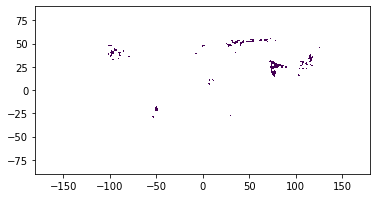

EPSG:4326
epsg:4326


In [35]:
# small check that rasters can be loaded correctly 
with rio.open(soybeam_images[1]) as im:
    show(im)
    raster_crs = im.crs

# load the study areas and check that it has the same crs as the rasters
areas = gpd.read_file(DATA_BASE_PATH/"areas.geojson")
areas["region"] = ["india", "america"]
print(raster_crs)
print(areas.crs)

# assert str(raster_crs).split(":")[1] == str(areas.crs).split(":")[1]

In [36]:
dest_dir = DATA_BASE_PATH/"areas"
dest_dir.mkdir(exist_ok=True)

In [39]:
def make_out_filename(image_path: Path, region: str) -> str:
    name, ext = image_path.name.split(".")
    return f"{name.replace('global', region)}.{ext}"

for im in soybeam_images:
    with rio.open(im) as src:
        # apply mask for each area and save new clipped raster
        for area in areas.itertuples():
            out_image, out_transform = mask(src, shapes=[area.geometry], crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            with rio.open(dest_dir/make_out_filename(im, area.region), "w", **out_meta) as dest:
                dest.write(out_image)

In [49]:
df = pd.read_csv("data/csv/spam2010V2r0_global_H_TA.csv", encoding="cp1252")

In [50]:
df.head()

,iso3,prod_level,alloc_key,cell5m,x,y,rec_type,tech_type,unit,whea_a,...,trof_a,temf_a,vege_a,rest_a,crea_date,year_data,source,name_cntr,name_adm1,name_adm2
0,CHN,CH08078,4383640,1891479,123.291667,53.541667,H,A,ha,0.0,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
1,CHN,CH08078,4393627,1895786,122.208333,53.458333,H,A,ha,0.0,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
2,CHN,CH08078,4393628,1895787,122.291667,53.458333,H,A,ha,0.0,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
3,CHN,CH08078,4393629,1895788,122.375000,53.458333,H,A,ha,7.5,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
4,CHN,CH08078,4393637,1895796,123.041667,53.458333,H,A,ha,1.5,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
